### Extreme Event Case Study: October 2007 Santa Ana winds + wildfire

Provide 2-3 sentences on the HDP purpose (victoria to provide)

Provide 2-3 sentences on historical context of the event

In [44]:
# imports
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import s3fs
import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point
import time  # Used for progress bar
import sys  # Used for progress bar
from case_study_eval_utils import *

import sys
import os

# Import qaqc stage plot functions
sys.path.append(os.path.abspath("../scripts/3_qaqc_data"))
from qaqc_plot import flagged_timeseries_plot, _plot_format_helper, id_flag


# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"

## Functions

### from qaqc_plot.py

In [56]:
def _plot_format_helper(var: str) -> tuple[str, str, float, float]:
    """
    Formatting helper function for variable names, units, ylabels.

    Parameters
    ----------
    var : str
        variable name being plotted

    Returns
    -------
    ylab : str
        variable name for y-axis
    unit : str
        units of variable
    miny : float
        min var value for y axis
    maxy : float
        max var value for y axis
    """

    pr_vars = [
        "pr",
        "pr_5min",
        "pr_15min",
        "pr_1h",
        "pr_24h",
        "pr_localmid",
    ]
    ps_vars = ["ps", "psl", "ps_derived", "ps_altimeter"]

    if var == "tas":
        ylab = "Air Temperature at 2m"
        unit = "K"

    elif var == "tdps" or var == "tdps_derived":
        ylab = "Dewpoint Temperature"
        unit = "K"

    elif var == "sfcWind":
        ylab = "Surface Wind Speed"
        unit = "$m s^{-1}$"

    elif var == "sfcWind_dir":
        ylab = "Surface Wind Direction"
        unit = "degrees"

    elif var == "rsds":
        ylab = "Surface Radiation"
        unit = "$W m^{-2}$"

    elif var == "hurs":
        ylab = "Humidity"
        unit = "%"

    elif var == "hurs_derived":  # added in hurs_derived
        ylab = "Humidity - derived"
        unit = "%"

    elif var in pr_vars:
        ylab = "Precipitation"
        unit = "mm"

    elif var == "accum_pr":
        ylab = "Annual Accumulated Precipitation"
        unit = "mm"

    elif var in ps_vars:
        ylab = "Pressure"
        unit = "Pa"

    elif var == "elevation":
        ylab = "Elevation"
        unit = "m"

    # ideally this would be in utils because it is in qaqc_wholestation
    T_X = {"North_America": 329.92}  # temperature, K
    T_N = {"North_America": 210.15}  # temperature, K
    D_X = {"North_America": 329.85}  # dewpoint temperature, K
    D_N = {"North_America": 173.15}  # dewpoint temperature, K
    W_X = {"North_America": 113.2}  # wind speed, m/s
    W_N = {"North_America": 0.0}  # wind speed, m/s
    R_X = {"North_America": 1500}  # solar radiation, W/m2
    R_N = {"North_America": -5}  # solar radiation, W/m2

    # for other non-record variables (wind direction, humidity)
    N_X = {"North_America": 360}  # wind direction, degrees
    N_N = {"North_America": 0}  # wind direction, degrees
    H_X = {"North_America": 100}  # humidity, max
    H_N = {"North_America": 0}  # humidity, min
    E_X = {"North_America": 6210.0}  # elevation, m
    E_N = {"North_America": -100}  # elevation, m

    # pressure, with elevation options
    S_X = {"North_America": 108330}  # pressure, Pa
    S_N = {"North_America": 87000}  # sea level pressure only, Pa
    SALT_N = {
        "North_America": 45960
    }  # non-sea level pressure, Pa, reduced min based on max elevation (6190 m)

    # precipitation, with variations depending on reporting interval
    P_X = {"North_America": 656}  # precipitation, mm, 24-hr rainfall
    PALT5_X = {"North_America": 31.8}  # precipitation, mm, 5-min rainfall, WECC-wide
    PALT15_X = {
        "North_America": 25.4
    }  # precipitation, mm, 15-min rainfall, specific to VALLEYWATER
    PACC_X = {
        "North_America": 10000
    }  # accumulated precipitation, mm, arbirtarily set to a high max value
    P_N = {"North_America": 0}  # precipitaiton, mm

    maxes = {
        "tas": T_X,
        "tdps": D_X,
        "tdps_derived": D_X,
        "sfcWind": W_X,
        "sfcWind_dir": N_X,
        "psl": S_X,
        "ps": S_X,
        "ps_derived": S_X,
        "ps_altimeter": S_X,
        "rsds": R_X,
        "pr": P_X,
        "pr_5min": PALT5_X,
        "pr_15min": PALT15_X,
        "pr_1h": P_X,
        "pr_24h": P_X,
        "pr_localmid": P_X,
        "accum_pr": PACC_X,
        "hurs": H_X,
        "hurs_derived": H_X, # added in hurs_derived
        "elevation": E_X,
    }
    mins = {
        "tas": T_N,
        "tdps": D_N,
        "tdps_derived": D_N,
        "sfcWind": W_N,
        "sfcWind_dir": N_N,
        "psl": S_N,
        "ps": SALT_N,
        "ps_derived": SALT_N,
        "ps_altimeter": SALT_N,
        "rsds": R_N,
        "pr": P_N,
        "pr_5min": P_N,
        "pr_15min": P_N,
        "pr_1h": P_N,
        "pr_24h": P_N,
        "pr_localmid": P_N,
        "accum_pr": P_N,
        "hurs": H_N,
        "hurs_derived": H_N,  # added in hurs_derived
        "elevation": E_N,
    }
    miny = mins[var]["North_America"]
    maxy = maxes[var]["North_America"]

    return ylab, unit, miny, maxy

### from case_study_eval_utils.py

In [50]:
def known_issue_check(network: str, var: str, stn: str):
    """
    Identifies if station under evaluation has a known network issue.
    At present, only prints out a statement if there is an issue.
    Eventually may want to do <something>

    Parameters
    ----------
    network : str
        Name of network to check
    var : str
        Name of variable to check
    stn : str
        Name of station to check

    Returns
    -------
    None

    Notes
    -----
    1. See "Known Network Issues for QA/QC Validation" planning doc.
    """
    print("Checking for known station issues...")

    # RAWS
    if network == "RAWS":
        if var == "tas":
            print(
                f"Known network issue for {network} {var}: values may be too high (on order of 10°F) if sun is shining strongly and winds are light."
            )

        elif var == "pr":
            print(
                f"Known network issue for {network} {var}: stations are not maintained in winter, instrument may freeze. Consider subsetting for May-September."
            )
            # V2 note: exclude RAWS data during specific notes -- would require new function to flag

    # SNOTEL
    if network == "SNOTEL":
        if var == "tas":
            print(
                f"Known network issue for {network} {var}: values may remain at exactly 0.0°C for two or more consecutive days. Should be caught by unusual_streaks."
            )
            print(
                f"Known network issue for {network} {var}: SNOTEL temperature sensors transition between mid-1990s and mid-2000s to new sensory type produces warm bias at \
            colder temperatures. Min temperature may be too high, max temperature may be too low."
            )
            # V2 note: trend analysis may identify these issues, nearest neighbor check could identify

    # ASOSAWOS + OtherISD
    if network == "ASOSAWOS":
        if var == "tdps":
            print(
                f"Known network issue for {network} {var}: values may be stuck at around 0.0°C, or have excessive mirror contamination. Should be caught by unsusual_streaks."
            )

    if network == "ASOSAWOS" or network == "OtherISD":
        if var == "pr":
            print(
                f"Known network issue for {network} {var}: ASOS network began installation in 1996, with poor instrumentation for measuring snowfall. Precipitation between \
            1980-1996 may be more likely to be flagged."
            )

    # CIMIS
    if network == "CIMIS":
        if var == "pr":
            print(
                f"Known network issue for {network} {var}: stations located in flat agricultural areas, sensor may be detecting sprinkler irrigation events. \
            Network does have stringent QC protocol."
            )
            # V2 note: nearest neighbor check could confirm

    # NDBC / MARITIME
    if network == "NDBC" or network == "MARITIME":
        print(
            f"Known network issue for {network}: some buoys have data past their known disestablishment dates. Should be caught by spurious_buoy_check."
        )

        if stn == "NDBC_46044":
            print(
                "Known network issue for NDBC_46044: buoy went adrift during reporting period. Confirm if data was flagged by QA/QC."
            )
            # V2 note: if not flagged, needs to be -- would require new function

        if (
            stn == "MARITIME_MTYC1"
            or stn == "MARITIME_MEYC1"
            or stn == "MARITIME_SMOC1"
            or stn == "MARITIME_ICAC1"
        ):
            print(
                f"Known network issue for {network} station {stn}: buoy was renamed and/or relocated. May cause issue for station proximity tests."
            )
            # V2 note: noted in qaqc_buoy_check but not handled -- would require new function

    return None


def subset_eval_stns(
    event_to_eval: str,
    stn_list: pd.DataFrame,
    specific_station: str | None = None,
    subset: int | None = None,
    return_stn_ids: bool = False,
) -> pd.DataFrame:
    """
    Identifies stations to evaluate for specific V1 QA/QC events.
    Option to subset to a more manageable number of random stations for initial evaluation.

    Parameters
    ----------
    event_to_eval : str
        options: santa_ana_wind, winter_storm, AR, mudslide, aug2020_heatwave, sep2020_heatwave, aug2022_heatwave, offshore_wind
    stn_list : pd.DataFrame
        station list
    specific_station : str, optional
        name of specific station to check
    subset : int, optional
        optional value to specify number of stations to return, useful for big events
    return_stn_ids : bool, optional
        Option to return string names for ease of use

    Returns
    -------
    eval_stns : pd.DataFrame
        Subset of stations relevant to a desired extreme event for analysis

    To Dos
    -------
    1. Validation check on event_to_eval options
    2. Need an option for "WECC wide" (or no spatial subsetting)
    3. Update station list being used here -- SNOTEL dates have been fixed.
    """

    event_flags = []
    event_flags.append("all")
    event_flags.append(event_to_eval)

    # grab stations per event
    event_stns = stn_list[stn_list["event_type"].isin(event_flags)]

    # exclude "manual check on end date" for time being -- SNOTEl stations all have 2100 as their end date regardless of when data actually ends
    mask = event_stns["notes"] == "manual check on end date"
    event_stns = event_stns[~mask]
    # print('{} potential stations available for evaluation for {} event!'.format(len(event_stns), event_to_eval))

    # identify stations in geographic region we are looking for
    ca_county = gpd.read_file(CENSUS_SHP)

    # different areas based on events
    if event_to_eval == "santa_ana_wind":
        counties_to_grab = [
            "Los Angeles",
            "Orange",
            "San Diego",
            "San Bernardino",
            "Riverside",
        ]

    elif event_to_eval == "winter_storm":
        # focus on Northern/Central/Bay Area to begin with // WECC wide
        counties_to_grab = [
            "Butte",
            "Colusa",
            "Del Norte",
            "Glenn",
            "Humboldt",
            "Lake",
            "Lassen",
            "Mendocino",
            "Modoc",
            "Nevada",
            "Plumas",
            "Shasta",
            "Sierra",
            "Siskiyou",
            "Tehama",
            "Trinity",
            "Alpine",
            "Amador",
            "Calaveras",
            "El Dorado",
            "Fresno",
            "Inyo",
            "Kings",
            "Madera",
            "Mariposa",
            "Merced",
            "Mono",
            "Placer",
            "Sacramento",
            "San Joaquin",
            "Stanislaus",
            "Sutter",
            "Yuba",
            "Tulare",
            "Tuolumne",
            "Yolo",
            "Alameda",
            "Contra Costa",
            "Marin",
            "Monterey",
            "Napa",
            "San Benito",
            "San Francisco",
            "San Mateo",
            "Santa Clara",
            "Santa Cruz",
            "Solano",
            "Sonoma",
        ]

    elif event_to_eval == "mudslide":
        counties_to_grab = ["Santa Barbara"]

    elif event_to_eval == "AR":
        counties_to_grab = []  # CA

    elif event_to_eval == "aug2020_heatwave":
        counties_to_grab = []  # CA

    elif event_to_eval == "sep2020_heatwave":
        counties_to_grab = [
            "San Luis Obispo",
            "Kern",
            "San Bernadino",
            "Santa Barbara",
            "Ventura",
            "Los Angeles",
            "Orange",
            "Riverside",
            "San Diego",
            "Imperial",
        ]

    elif event_to_eval == "aug2022_heatwave":
        # August 2022 -- Labor Day Heatwave "aug2022_heatwave"
        counties_to_grab = [
            "San Luis Obispo",
            "Kern",
            "San Bernadino",
            "Santa Barbara",
            "Ventura",
            "Los Angeles",
            "Orange",
            "Riverside",
            "San Diego",
            "Imperial",
        ]

    elif event_to_eval == "offshore_wind":
        counties_to_grab = [
            "San Diego",
            "Orange",
            "Los Angeles",
            "Ventura",
            "Santa Barbara",
            "San Luis Obispo",
            "Monterey",
            "Santa Cruz",
            "San Mateo",
            "Santa Clara",
            "Alameda",
            "San Francisco",
            "Contra Costa",
            "Solano",
            "Marin",
            "Sonoma",
            "Mendocino",
            "Humboldt",
            "Del Norte",
        ]

    target_counties = ca_county[ca_county["NAME"].isin(counties_to_grab)]
    target_counties = GeoDataFrame(target_counties, geometry=target_counties.geometry)

    geometry = [
        Point(latlon_to_mercator_cartopy(lat, lon))
        for lat, lon in zip(event_stns.latitude, event_stns.longitude)
    ]
    event_stns = GeoDataFrame(event_stns, geometry=geometry).set_crs(
        crs="EPSG:3857", allow_override=True
    )
    # adding geometry column
    event_stns_local = gpd.overlay(event_stns, target_counties, how="intersection")
    num_event_stns_local = len(event_stns_local)
    # subsetting for stations within county boundaries
    print(
        f"{num_event_stns_local} potential stations available for evaluation for {event_to_eval} event."
    )

    # Check if a specific_station is requested and return that one
    if specific_station is not None:
        eval_stns = event_stns[event_stns["era-id"] == specific_station]
        if len(eval_stns) == 0:
            raise ValueError(
                f"Station {specific_station} is not within the training/event dataset"
            )
        return eval_stns

    if subset != None:
        if num_event_stns_local <= subset:
            eval_stns = event_stns_local
        else:
            eval_stns = event_stns_local.sample(subset, replace=False)
            print(
                f"{subset} stations selected for evaluation for {event_to_eval} event!"
            )
    else:
        eval_stns = event_stns_local

    if return_stn_ids:
        print("Stations selected for evaluation:\n", list(eval_stns["era-id"]))

    return eval_stns


def id_all_flags(ds: xr.Dataset):
    """
    Prints all unique values of all eraqaqc flags

    Parameters
    ----------
    ds : xr.Dataset
        station data in xr format (not pd.DataFrame)

    Returns
    -------
    None
    """

    ds_vars = list(ds.keys())
    qc_vars = [i for i in ds_vars if "_eraqc" in i]
    if len(qc_vars) == 0:
        print(
            "Station has no eraqc variables -- please double check that this station has completed QA/QC!"
        )
    else:
        for var in qc_vars:
            print(var, np.unique(ds[var].data))

    return None


def event_info(
    event: str, alt_start_date: str | None = None, alt_end_date: str | None = None
) -> tuple[str, str]:
    """
    Utility function to return useful information for a specific designated event.

    Paramters
    ---------
    event : str
        name of event to evaluate
    alt_start_date : str
        date of different event, must be in format "YYYY-MM-DD"
    alt_end_date : str
        date of different event, must be in format "YYYY-MM-DD"

    Returns
    -------
    tuple[str, str]
        start and end dates for requested event

    To dos
    ------
    1. Alternative start / end date format check
    """

    start_date = {
        "santa_ana_wind": "2007-10-19",
        "winter_storm": "1990-12-20",
        "AR": "2017-01-16",
        "mudslide": "2018-01-05",
        "aug2020_heatwave": "2020-08-14",
        "sep2020_heatwave": "2020-09-05",
        "aug2022_heatwave": "2022-08-30",
        "offshore_wind": "2021-01-15",
        "alternative": alt_start_date,
    }

    end_date = {
        "santa_ana_wind": "2007-11-16",
        "winter_storm": "1990-12-24",
        "AR": "2017-01-20",
        "mudslide": "2018-01-09",
        "aug2020_heatwave": "2020-08-15",
        "sep2020_heatwave": "2020-09-08",
        "aug2022_heatwave": "2022-09-09",
        "offshore_wind": "2021-01-16",
        "alternative": alt_end_date,
    }

    event_start = start_date[event]
    event_end = end_date[event]

    return (event_start, event_end)


def event_subset(
    df: pd.DataFrame,
    event: str,
    buffer: int | None = 7,
    alt_start_date: str | None = None,
    alt_end_date: str | None = None,
) -> pd.DataFrame:
    """
    Subsets for the event itself + buffer around to identify event.

    Parameters
    ---------
    df: pd.DataFrame
        stationlist dataframe
    event : str
        name of event
    buffer : int, optional
        number of days to include as a buffer around event start/end date
    alt_start_date : str
        date of different event, must be in format "YYYY-MM-DD"
    alt_end_date : str
        date of different event, must be in format "YYYY-MM-DD"

    Returns
    -------
    event_sub : pd.DataFrame
        subset of stationlist within date range of event or alternative
    """

    print(
        f"Subsetting station record for event duration with {str(buffer)} day buffer..."
    )

    # set to searchable datetime
    df["time"] = pd.to_datetime(df["time"])
    # grab dates from lookup dictionary
    event_start, event_end = event_info(event, alt_start_date, alt_end_date)

    # subset for event dates + buffer
    datemask = (
        df["time"] >= (pd.Timestamp(event_start) - datetime.timedelta(days=buffer))
    ) & (df["time"] <= (pd.Timestamp(event_end) + datetime.timedelta(days=buffer)))
    event_sub = df.loc[datemask]

    return event_sub


def flags_during_event(subset_df: pd.DataFrame, var: str, event: str) -> list[str]:
    """
    Provides info on which flags were placed during event for evaluation

    Parameters
    ---------
    subset_df : pd.DataFrame

    var : str
        name of variable to assess flags
    event : str
        name of case study event

    Returns
    -------
    all_event_flags : list[str]
        all event flags set
    """

    event_flags = subset_df[var + "_eraqc"].unique()
    print(f"Flags set on {var} during {event} event: {event_flags}")
    all_event_flags = []
    for item in subset_df[var + "_eraqc"].unique():
        all_event_flags.append(item)

    return all_event_flags


def find_other_events(
    df, event_start, event_end, buffer=14, subset=None, return_stn_ids=True
):
    """
    Event finder not tied to specified case study events.

    Parameters
    ---------
    df : pd.DataFrame
        stationlist
    event_start : str
        start of event, format "YYYY-MM-DD"
    event_end : str
        end of event, format "YYYY-MM-DD"

    Returns
    -------
    eval_stns : pd.DataFrame
        subset of stations for other events of interest

    To dos
    ------
    1. Manual end date check no longer relevant, make sure stationlist passed is the correct updated version.
    2. Start / end date format check
    """

    print(
        f"Subsetting station record for event duration with {str(buffer)} day buffer..."
    )

    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])
    event_start = pd.to_datetime(event_start).tz_localize("UTC")
    event_end = pd.to_datetime(event_end).tz_localize("UTC")

    event_sub = df.loc[
        (df["start_date"] <= (event_start - datetime.timedelta(days=buffer)))
        & (df["end_date"] >= (event_end + datetime.timedelta(days=buffer)))
    ]

    # exclude "manual check on end date" stations since we don't know when they actually end
    event_sub = event_sub.loc[event_sub["notes"] != "manual check on end date"]

    # subset to make more manageable
    if subset != None:
        if len(event_sub) <= subset:
            eval_stns = event_sub
        else:
            eval_stns = event_sub.sample(subset, replace=False)
            print(f"{subset} stations selected for evaluation for comparison!")
    else:
        eval_stns = event_sub

    # return station ids for ease
    if return_stn_ids:
        print("Stations selected for evaluation:\n", list(eval_stns["era-id"]))

    return eval_stns


def latlon_to_mercator_cartopy(lat: float, lon: float) -> tuple[float, float]:
    """
    Converts lat/lon coordinates to mercator for plotting.

    Parameters
    ---------
    lat : float
        latitude
    lon : float
        longitude

    Returns
    -------
    tuple[float, float]
    """

    proj_latlon = CRS("EPSG:4326")
    proj_mercator = CRS("EPSG:3857")

    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x, y = transformer.transform(lon, lat)

    return x, y


def stn_visualize(stn_id, stn_list, event_to_eval):
    """
    Produces simple map of station relevant to event boundary.

    Parameters
    ----------
    stn_id : str
        name of station
    stn_list : pd.DataFrame
        stationlist
    event_to_eval : str
        name of case study event

    Returns
    -------
    None
    """

    # grab station id info and reproject coords
    stn = stn_list.loc[stn_list["era-id"] == stn_id]
    lon, lat = stn.longitude.values[0], stn.latitude.values[0]
    x, y = latlon_to_mercator_cartopy(lat, lon)

    # figure set-up
    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.epsg(3857)})
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES, lw=0.5)

    ax.set_extent([lon + 1, lon - 1, lat - 1, lat + 1])

    # Obtain the limits of the plot
    x0, x1, y0, y1 = ax.get_extent()

    # Create a polygon with the limits of the plot
    polygon = Polygon(((x0, y0), (x0, y1), (x1, y1), (x1, y0)))

    # Use only the counties that overlap with the actual plot
    ca_county = gpd.read_file(CENSUS_SHP)
    counties = ca_county[ca_county.overlaps(polygon)]

    # Plot the counties' geometries
    for geometry in counties.geometry:
        ax.add_geometries(
            geometry.boundary,
            crs=ax.projection,
            facecolor="none",
            edgecolor="teal",
            lw=0.5,
        )

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.plot(lon, lat, "ok", markersize=8, transform=ccrs.PlateCarree(), mfc="none")
    ax.plot(x, y, ".r", markersize=4)
    ax.annotate(f"{stn_id}", xy=(x, y), xytext=(x + 10, y + 10), fontsize=6)
    # station name
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"], ls=":", lw=0.5
    )
    ax.set_title(f"{event_to_eval} evaluation \nat {stn_id}")

    return None


def event_plot(
    df: pd.DataFrame,
    var: str,
    event: str,
    alt_start_date: str | None = None,
    alt_end_date: str | None = None,
    dpi: int | None = None,
):
    """Produces timeseries of variables that have flags placed

    Parameters
    ----------
    df : pd.DataFrame
        stationlist
    var : str
        name of variable
    event : str
        name of case study event
    alt_start_date : str
        date of different event, must be in format "YYYY-MM-DD"
    alt_end_date : str
        date of different event, must be in format "YYYY-MM-DD"
    dpi : int
        figure resolution

    Returns
    -------
    None
    """

    fig, ax = plt.subplots(figsize=(10, 3))

    # plot all observations
    df.plot(
        ax=ax,
        x="time",
        y=var,
        marker=".",
        ms=4,
        lw=1,
        color="k",
        alpha=0.5,
        label="Cleaned data",
    )

    # plot event timeline
    event_start, event_end = event_info(event, alt_start_date, alt_end_date)
    ax.axvspan(event_start, event_end, color="red", alpha=0.1, label="{}".format(event))

    # ax.axhline(event_start, color='red', lw=2, alpha=0.25)
    # ax.axhline(event_end, color='red', lw=2, alpha=0.25)
    # ax.fill_between(x='time', 0, 1, where=y)

    # plot any flags placed by QA/QC
    if len(df[var + "_eraqc"].dropna().unique()) != 0:
        # identify flagged data, can handle multiple flags
        for flag in df[var + "_eraqc"].dropna().unique():
            flag_name = id_flag(flag)
            flag_str = 100 * len(df.loc[df[var + "_eraqc"] == flag, var]) / len(df)
            flag_label = f"{flag_str:.3f}% of data flagged by {flag_name}"

            flagged_data = df[~df[var + "_eraqc"].isna()]
            flagged_data.plot(
                x="time",
                y=var,
                ax=ax,
                marker="o",
                ms=7,
                lw=0,
                mfc="none",
                color="C3",
                label=flag_label,
            )

    legend = ax.legend(loc="upper left", prop={"size": 8})

    # plot aesthetics
    ylab, units, miny, maxy = _plot_format_helper(var)
    plt.ylabel(f"{ylab} [{units}]")
    plt.xlabel("")
    stn = df["station"].unique()[0]
    plt.title(
        f"QA/QC event evaluation: {event}: {stn}",
        fontsize=10,
    )

    return None

## Step 1:

In [ ]:
# using google doc for event
# subset all stations for time dates, probably within a 2 week window on either side
# depending on the event, susbet for specific variables (ask Victoria)

In [ ]:
# Read in a list of weather stations
# We just use the names of the stations to filter
# Ideally I'd like to see this moved to the AWS bucket
train_stns = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

# Create new geometry column from lat and lon columns
# This will enable us to filter through the GeoDataFrame using our county geometry
train_stns = gpd.GeoDataFrame(
    train_stns,
    geometry=gpd.points_from_xy(
        train_stns.longitude, train_stns.latitude, crs="EPSG:4326"
    ),
)
# train_stns.head()

In [ ]:
# Read in county shapefiles from S3
ca_counties = gpd.read_file(
    "s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp"
)
ca_counties = ca_counties.to_crs(train_stns.crs)  # Convert to station CRS
# ca_counties.head()

In [ ]:
event_start_date = "2007-10-05"  # Start a few days before the mudslide
event_end_date = "2007-11-30"

event_geom = ca_counties[ca_counties["NAME"] == "San Diego"]  # Get event geometry

In [ ]:
train_stns["intersects"] = train_stns.intersects(
    event_geom.unary_union
)  # See which stations intersect with the event polygon
event_stns = train_stns[train_stns["intersects"] == True].reset_index(
    drop=True
)  # Get just those stations, drop the others
event_stns

In [ ]:
# Make a plot to visualize the stations and event poly
fig, ax = plt.subplots()
event_geom.boundary.plot(color="black", ax=ax, zorder=10)
event_stns.geometry.plot(markersize=15, ax=ax, zorder=15)

In [ ]:
# subset for variables of interest
event_stns.columns
# sfcWind, hurs, pr, pr_24h, pr_1h, pr_5min, pr_localmid

# Victoria
# sfcWind, relative humidity, air temp
# usually massive drop in hum and bump in air temp for stana ana wind events, should see temp going up and hurs staying low even afte wind event has died down
# wind direction also
# should see winds staying low
# winds help push wildfires out, but also put it out
# should see bump in sfcwind

# sum up:
# wind speed, secondarily wind diraction (less), air temp, relative hum
# should see winds rel low, variable, then leading into event see spike in wind speed, fairly unidirectional wind direction from NE to SW, then after wind event has ended, wind speed drops down
# during peak of wind, see bump in tem (and diuran) and plummeting of rh
# as wind event dies, air temp stays high if not approach world records (for wildfire) and rh stay low

# any functions I devleop, make sure methods are consistent, put those functions into the script

# Victoria will start on case study next week


In [27]:
url = f"s3://{BUCKET_NAME}/{MERGE_DIR}/ASOSAWOS/ASOSAWOS_72293193107.zarr"
ds = xr.open_zarr(url)
df = ds.to_dataframe()
df = df.reset_index()

In [17]:
event_info("santa_ana_wind","2007-10-05","2007-11-30")

('2007-10-19', '2007-11-16')

In [28]:
subset = event_subset(df, 'santa_ana_wind', 7)

Subsetting station record for event duration with 7 day buffer...


In [33]:
flags_during_event(subset, 'hurs_derived', 'santa_ana_wind')

Flags set on hurs_derived during santa_ana_wind event: [nan]


[nan]

In [35]:
stn_list = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


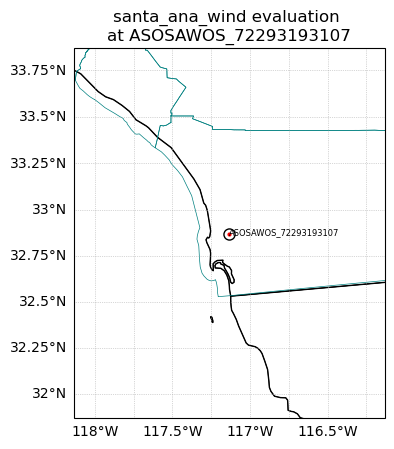

In [36]:
stn_visualize("ASOSAWOS_72293193107", stn_list, "santa_ana_wind")

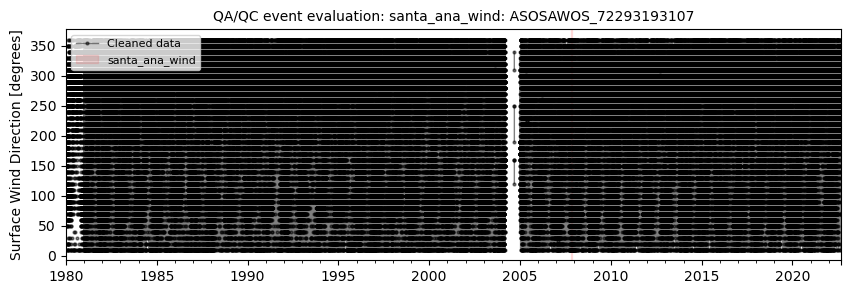

In [60]:
event_plot(df, "sfcWind_dir", "santa_ana_wind")

wind speed, secondarily wind diraction (less), air temp, relative hum

'hurs_derived' - relative humidity, derived

'sfcWind' - wind speed at 10m

'sfcWind_dir' - wind direction

no air temp

In [58]:
df.columns

Index(['station', 'time', 'elevation', 'elevation_eraqc', 'hurs_derived',
       'hurs_derived_eraqc', 'lat', 'lon', 'pr', 'pr_eraqc', 'ps',
       'ps_altimeter', 'ps_altimeter_eraqc', 'ps_eraqc', 'psl', 'psl_eraqc',
       'sfcWind', 'sfcWind_dir', 'sfcWind_dir_eraqc', 'sfcWind_eraqc', 'tas',
       'tas_eraqc', 'tdps', 'tdps_eraqc'],
      dtype='object')

## Step 2:

In [ ]:
# produce simple timeseries plots of variable over the event
# include QC flags
# if possible, add shaded bars or something (look at old code) to indicate the event itself

In [ ]:
event_stns.head(3)

In [ ]:
df = pd.read_csv()

In [ ]:
df.plot(
    ax=ax,
    x="time",
    y=var,
    marker=".",
    ms=4,
    lw=1,
    color="k",
    alpha=0.5,
    label="Cleaned data",
)

## Step 3:

In [ ]:
# some kind of map

In [ ]:
# table / stats "read out" on extremes during the event

In [ ]:
# table / stats "read out" on QC flags, including if we think refinement to QC tests would improve coverage

In [ ]:
# some function/thing in terms of how many stations "detected" the event

In [ ]:
# summary information via markdown close out of what we have learned